In [1]:
from LIMxCMBL.init import *
from LIMxCMBL.noise import *

In [2]:
# CCAT-prime
zmin = 3.5
zmax = 8.1

Omega_field = 8 * (np.pi/180)**2 #rad^2
Pei = 2.3e4 #Mpc^3 kJy^2 /sr^2 
chimin = ccl.comoving_angular_distance(cosmo, 1/(1+zmin))
chimax = ccl.comoving_angular_distance(cosmo, 1/(1+zmax))

# Checking units
The units of general cross spectrum is like 
$$[K_\Phi][K_\psi] \times \frac 1 {[\chi]} \times [P^{\Phi\Psi}]$$
where we have
$$[\chi] = {\sf Mpc}$$
$$[K_\kappa] = {\sf dimensionless} $$
$$[K_{\rm LIM}] = \frac{\sf kJy}{\sf sr}\times\frac 1 {[\chi]} $$
$$[K_{\rm LIM}^{\sf Lo}] =  \frac{\sf kJy}{\sf sr} \times \frac 1 {[\chi]}$$
$$[K_{\rm LIM}^{\epsilon}] = \frac 1 {[\chi]}$$
$$[P_m] = {\sf Mpc}^3 $$
$$[P^{\epsilon_I}] = {\sf Mpc}^3\times \frac{\sf kJy^2}{\sf sr^2} $$
Note for last one, in Gabi's paper tis report in terms of Jy/sr

$$[\mathcal O_\ell^\kappa] =  1\times 1 \times \frac 1 {\sf Mpc}\times {\sf Mpc}^3 = {\sf Mpc}^2$$
$$[\mathcal O_\ell^{I,\kappa}]=[\mathcal O_\ell^{{\sf Hi},\kappa}] = [\mathcal O_\ell^{{\sf Lo},\kappa}] =  \frac{\sf kJy}{\sf sr} \frac 1 {\sf Mpc}\times 1\times \frac 1 {\sf Mpc}\times {\sf Mpc}^3 = \frac{\sf kJy}{\sf sr}\times {\sf Mpc}$$
$$[\mathcal O_\ell^{{\sf Hi},{\sf Hi}}]=\dots =  \frac{\sf kJy}{\sf sr} \frac 1 {\sf Mpc}\times  \frac{\sf kJy}{\sf sr} \frac 1 {\sf Mpc}\times \frac 1 {\sf Mpc}\times {\sf Mpc}^3 = \frac{\sf kJy^2}{\sf sr^2}$$
$$[\mathcal N_\ell^{{\sf Hi}}(\chi,\chi')]= \frac 1 {\sf Mpc} \frac 1 {\sf Mpc} \times \frac 1 {\sf Mpc} \times {\sf Mpc}^3\frac{\sf kJy^2}{\sf sr^2} = \frac{\sf kJy^2}{\sf sr^2}$$
$$\textrm{(Noise diagonal approx)}\ [\mathcal N_\ell^{{\sf Hi}}(\chi)]= {\sf Mpc}\frac{\sf kJy^2}{\sf sr^2}$$

$$[{\sf var}] = \frac 1 {N_\ell}[\sf kJy^2 sr^{-2} Mpc^2 + {\sf same}]$$

[]

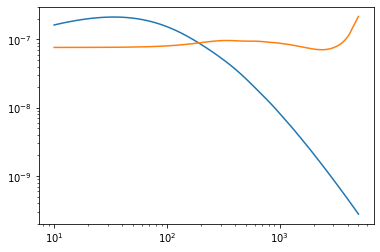

In [3]:
# get CMB lensing component
from LIMxCMBL.kernels import get_f_Kkappa
f_WkD = get_f_Kkappa()

from LIMxCMBL.cross_spectrum import *
ClKK = d_chib_integral(f_WkD, f_WkD) #[Mpc]^2


# beam=1.4, noise=7
from scipy.interpolate import interp1d
N0_ells = np.logspace(1, np.log10(5000), 500)
with open('LIMxCMBL/N0.npy', 'rb') as f:
    N0 = np.load(f)
    
f_N0 = interp1d(x = N0_ells, y = N0)

    
plt.plot(ells, ClKK)
plt.plot(ells, f_N0(ells))
plt.loglog()

In [4]:
# if no high pass IKappa
from  LIMxCMBL.kernels import *
f_KLIM   = get_f_KI()
f_Kkappa = get_f_Kkappa()

f_KLIM_windowed = apply_window(f_K = f_KLIM,
                               chimin = chimin,
                               chimax = chimax)
I_kappa = d_delta_integral(f_KLIM_windowed, f_Kkappa) #[kJy / sr ] [Mpc]

In [5]:
from scipy.integrate import trapezoid, simpson, quad_vec
from scipy.interpolate import interp1d


In [7]:
Lambdas = np.logspace(-5, 0, 50)

In [8]:
from tqdm import trange, tqdm

In [12]:
window = np.where((chis_resample > chimin) & (chis_resample < chimax))[0]

In [16]:
SNR2_per_mode = {}
integrand =  I_kappa**2 / (1/chis_resample**2)
SNR2_per_mode[0.0] = trapezoid(x = chis_resample, y = integrand)/(ClKK + f_N0(ells)) 
for Lambda in tqdm(Lambdas):
#     print(Lambda)
    chis_resample_len = int(np.log2(len(chis_resample)))
    IHi_kappa_fname = '/scratch/users/delon/LIMxCMBL/IHiKappa/zmin_%.5f_zmax_%.5f_Lambda_%.5f_chi_sample_2e%d.npy'%(zmin, zmax, Lambda,chis_resample_len)
    IHi_kappa = np.load(IHi_kappa_fname) #[kJy/sr Mpc]

    integrand =  IHi_kappa**2 / (1/chis_resample**2) # [kJy^2/sr^2][Mpc^4]
    
    # total integral has unit #[kJy^2 / sr^2][Mpc^3] 
    SNR2_per_mode[Lambda] = simpson(x = chis_resample[window], 
                                    y = integrand[:,window])/(ClKK + f_N0(ells)) 

100%|██████████| 50/50 [00:01<00:00, 30.29it/s]


In [17]:
Lambdas = np.array(sorted(list(SNR2_per_mode.keys())))

In [18]:
rainbow_colors = plt.cm.rainbow(np.linspace(0, 1, len(SNR2_per_mode)))
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=rainbow_colors[::-1])

Text(0.5, 0, 'ells')

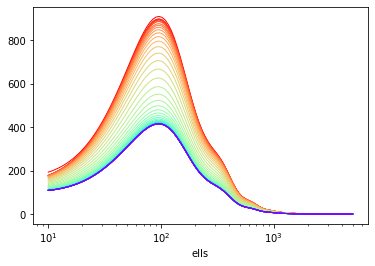

In [19]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, SNR2_per_mode[Lambda], label=label, lw = 1)
plt.xscale('log')
plt.xlabel('ells')
# plt.legend(frameon=False)

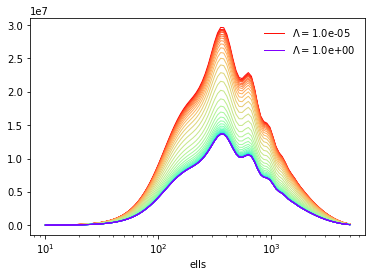

In [20]:
plt.figure(facecolor = 'w')
for Lambda in SNR2_per_mode:
    label = None
    if(Lambda == 1e-5 or Lambda == 1e0):
        label = r'$\Lambda=$%.1e'%(Lambda)
    plt.plot(ells, ells**2 * SNR2_per_mode[Lambda], label=label, lw = 1)

plt.xscale('log')
plt.xlabel('ells')
plt.legend(frameon=False)

In [22]:
plt.show()
plt.rcParams['text.usetex'] = True

In [23]:
SNR2_per_Omega_per_invPei = np.zeros_like(Lambdas)
for Lambda_idx in range(len(Lambdas)):
    Lambda = Lambdas[Lambda_idx]
    #[kJy^2 / sr^2][Mpc^3] \times 1/angle^2
    summand = SNR2_per_mode[Lambda] * ells ** 2 
    
    # [kJy^2 / sr^2][Mpc^3] \times 1/angle^2
    SNR2_per_Omega_per_invPei[Lambda_idx] = trapezoid(x = np.log(ells), 
                                           y = SNR2_per_mode[Lambda] * ells ** 2 / 2 / np.pi)

Text(0, 0.5, '$${\\sf SNR}^2 \\times \\frac 1 {{\\Omega}\\ [\\sf rad^2]}\\times {P^{\\epsilon_I}}\\left[\\sf Mpc^{3}\\frac{\\sf kJy^2}{\\sf sr^2} \\right]$$')

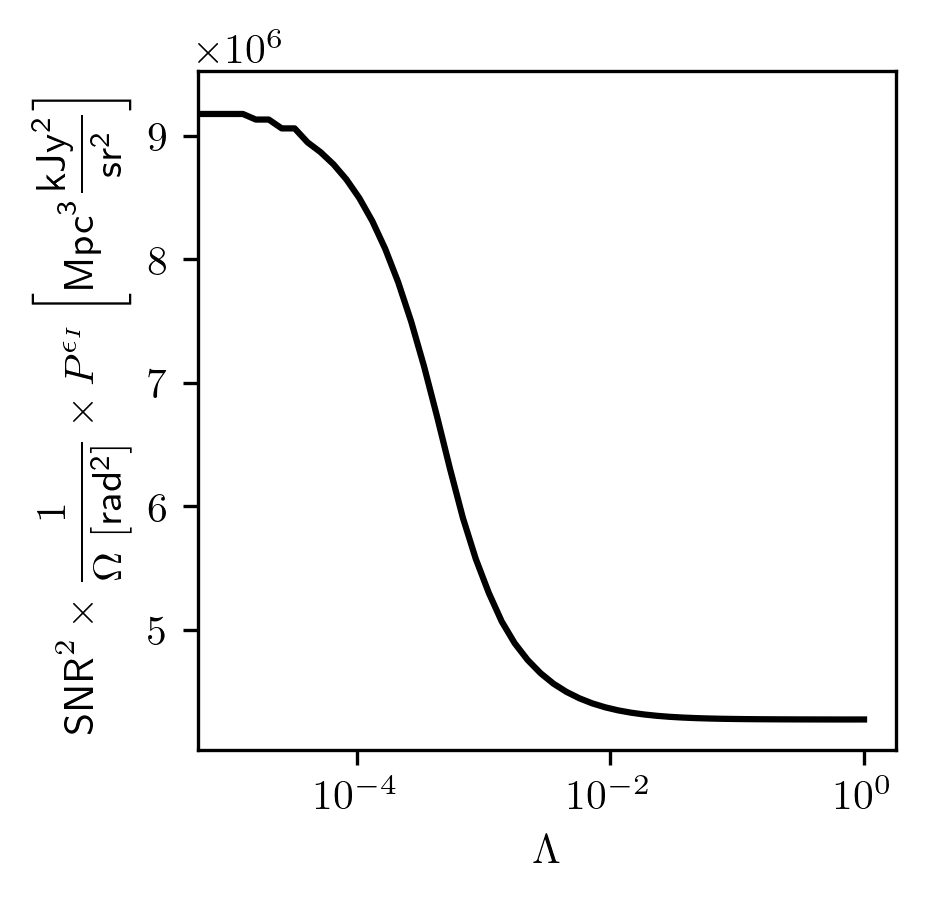

In [24]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

plt.plot(Lambdas, (SNR2_per_Omega_per_invPei), c='k')
plt.xscale('log')
fundamental = 2*np.pi/(chimax - chimin)

plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2 \times \frac 1 {{\Omega}\ [\sf rad^2]}\times {P^{\epsilon_I}}\left[\sf Mpc^{3}\frac{\sf kJy^2}{\sf sr^2} \right]$$')

Text(0, 0.5, '$${\\sf SNR}^2 \\times \\frac 1 {{\\Omega}\\ [\\sf rad^2]}\\times {P^{\\epsilon_I}}\\left[\\sf Mpc^{3}\\frac{\\sf kJy^2}{\\sf sr^2} \\right]$$')

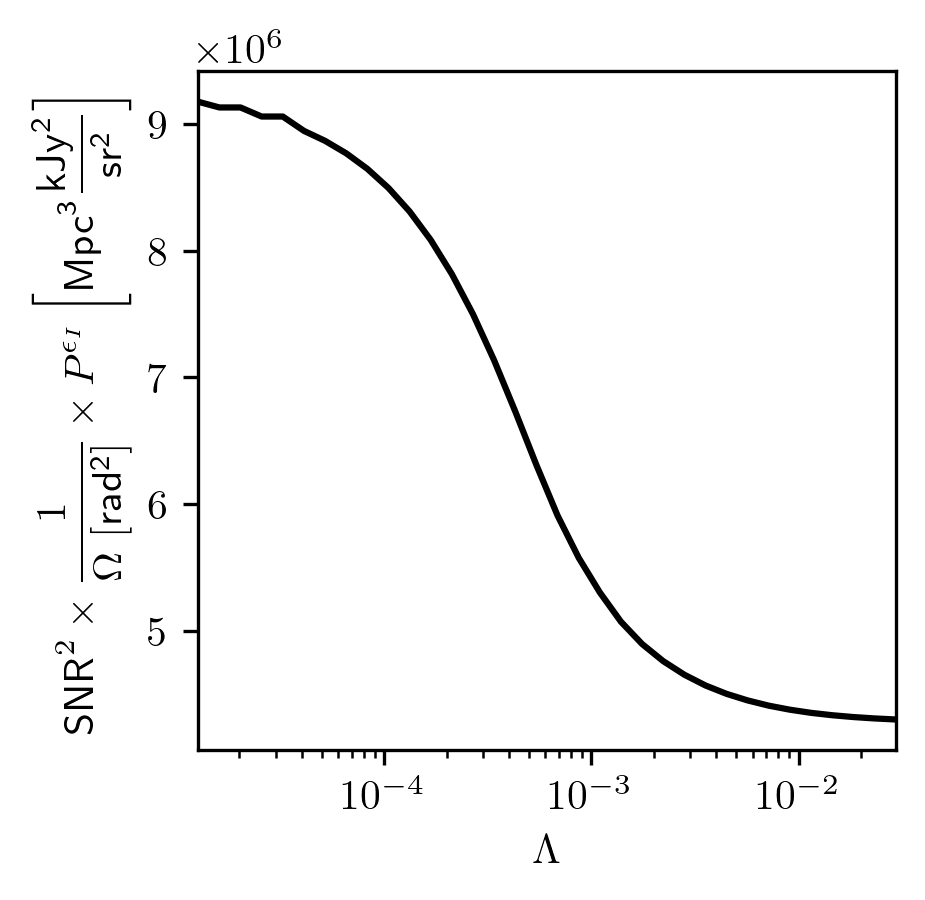

In [25]:
cut = np.where((Lambdas > 1e-5) & (Lambdas < 3e-2))

plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')

# for i in range(10):
#     plt.axvline(fundamental * i, c='lightgrey')

plt.plot(Lambdas[cut], (SNR2_per_Omega_per_invPei)[cut], c='k')
plt.xscale('log')
fundamental = 2*np.pi/(chimax - chimin)

plt.xlim(Lambdas[cut][0], Lambdas[cut][-1])
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}^2 \times \frac 1 {{\Omega}\ [\sf rad^2]}\times {P^{\epsilon_I}}\left[\sf Mpc^{3}\frac{\sf kJy^2}{\sf sr^2} \right]$$')

Text(0.5, 1.0, 'CCAT-Prime')

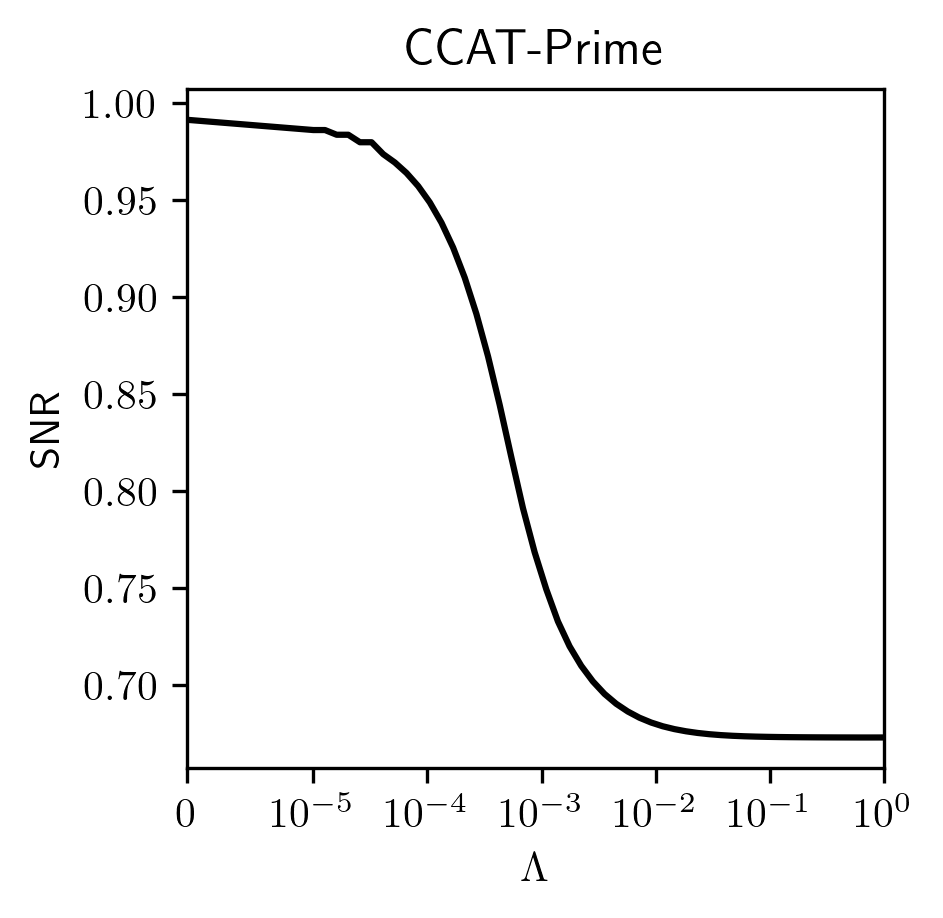

In [32]:
plt.figure(figsize = (3,3) ,dpi = 300, facecolor = 'w')
plt.plot(Lambdas, np.sqrt(SNR2_per_Omega_per_invPei) * np.sqrt(Omega_field) / np.sqrt(Pei), c='k')
plt.xscale('symlog', linthresh = 1e-5)
fundamental = 2*np.pi/(chimax - chimin)

plt.xlim(0, 1e0)
plt.xlabel(r'$\Lambda$')
plt.ylabel(r'$${\sf SNR}$$')
plt.title('CCAT-Prime')